# Keyword spotting

Keyword spotting (KWS) is a typical problem defined in the context of speech processing. A special case of KWS is the case of wake word detection that is commonly used by personal digital assistants as Alexa and Siri to “wake up” when their command is spoken. This is not the case of speech recognition, that needs much more complex systems and structures, but this approach can be used to identify a set of commands to operate on a personal device.

The objective of this lab is to experiment with a workflow for training a simple network that can learn how to detect know commands in one second of audio, e.g., 'up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no'.

**Note.** The notebook modifies the Pytorch tutorial on [Speech Command Classification with Torchaudio](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) by using both Waveform and Mel Spectrogram as input to the Network Model and, optionally, using [*audio feature augmentation*](https://pytorch.org/audio/main/tutorials/audio_feature_augmentation_tutorial.html).

## Preliminaries

Before starting, review or have ready the following material:

* Lesson "14. Machine and Deep Learning for Audio" slides and recording

* Pytorch tutorial on Speech Command Classification
https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

* Pytorch tutorial on Audio Feature Extractions to compute and represent the Mel Spectrogram
https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

* Pytorch tutorial on Audio Data Augmentation to extend the set of samples fo the training
https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html



## Importing libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import librosa
import torchvision
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd

from tqdm import tqdm
%matplotlib inline

from torchsummary import summary


### Get Computational Device




In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209), which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is being accessed, and torchaudio takes care of converting the audio files to tensors. If one wants to load an audio file directly instead, `torchaudio.load()` can be used. It returns a tuple containing the newly created tensor along with the sampling frequency of the audio file (16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into standard training, validation, testing subsets.

**Note.** In order to speed up the learning process, we restrict the number of different commands to a subset of the original thirtyfive commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'] (see the `commands` set).




commands = {'up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no'}

In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, labels = {}):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        def filter_labels(walker):
            return [ w for w in walker if os.path.split(os.path.split(w)[0])[1] in labels ]

        # labels = { 'yes', 'no' }

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes ]

        # for i, file_path in enumerate(self._walker):
        #     print(subset, get_label(file_path), file_path)
        if len(labels):
          self._walker = filter_labels(self._walker)


# Limit to a subset of all the 35 commands
commands = {'up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no'}
print("Selected command subset from the dataset: ", commands);





Selected command subset from the dataset:  {'stop', 'go', 'right', 'yes', 'down', 'up', 'left', 'no'}


In [6]:
# Create training and testing split of the data.
train_set = SubsetSC("training", commands)
test_set = SubsetSC("testing", commands)
valid_set = SubsetSC("validation", commands)

## Exploring the data

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.

**Task: Waveform Plot.** Select a sample from the dataset (e.g., idx=1), plot the waveform and print its shape. Listen to the same sample with “ipd.Audio(<waveform>, <rate>)”

```
Train set length: 24713
Test set length: 3276
Sample metadata. Label: down, Speaker: 004ae714, Utterance no. 0
Shape of waveform: torch.Size([1, 16000])
  Number of channels: 1
  Number of samples: 16000
Sample rate of waveform: 16000 Hz
```

![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/0a3cace1bcae8518e974a270c3b6fbb8acb01a7c/utterance-waveform.png)




Train set length: 24713
Test set length: 3276
Sample metadata. Label: down, Speaker: 004ae714, Utterance no. 0
Shape of waveform: torch.Size([1, 16000])
  Number of channels: 1
  Number of samples: 16000
Sample rate of waveform: 16000 Hz


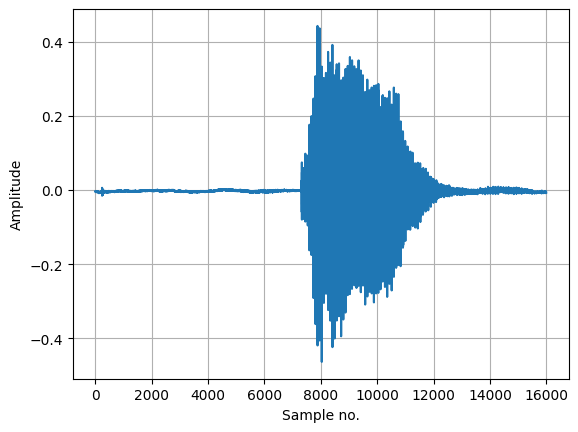

In [10]:
print(f"Train set length: {len(train_set)}")
print(f"Test set length: {len(test_set)}")

idx = 1

waveform, sample_rate, label, speaker_id, utterance_number = train_set[idx]

print(f"Sample metadata. Label: {label}, Speaker: {speaker_id}, Utterance no. {utterance_number}")
print("Shape of waveform: {}".format(waveform.size()))
print("  Number of channels: {}".format(waveform.size()[0]))
print("  Number of samples: {}".format(waveform.size()[1]))
print("Sample rate of waveform: {} Hz".format(sample_rate))

# TASK: WAVEFORM PLOT
plt.plot(range(waveform.size()[1]), waveform[0])
plt.xlabel('Sample no.')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


Run the following cell and listen to the sample.



In [ ]:
print(f"Listen to sample no. {idx} with utterance_number: {utterance_number}")
print(f" Speaker {speaker_id} saying '{label}'")
print()

ipd.display(ipd.Audio(waveform.numpy(), rate=sample_rate))

Listen to sample no. 1 with utterance_number: 0
 Speaker 004ae714 saying 'down'



Let’s find the list of labels available in the dataset. (it takes at least 1.5 minutes)




In [11]:
print(f"Counting number of labels in the dataset (be patient) ...")

# or just list the command subset
# labels = list(commands)
counts = pd.Series(datapoint[2] for datapoint in train_set).value_counts();
labels = [ lbl for lbl, cnt in counts.items()]
print(labels)
counts

Counting number of labels in the dataset (be patient) ...
['yes', 'down', 'no', 'stop', 'go', 'left', 'right', 'up']


yes      3228
down     3134
no       3130
stop     3111
go       3106
left     3037
right    3019
up       2948
Name: count, dtype: int64

## Mel Spectrogram

**Task: Mel Spectrogram.** Use _Torchaudio transforms_ to transform the sample data in an image, i.e., the Mel Spectrogram. First just use the default parameters, then follow the Pytorch tutorial on [Audio Feature Extractions](https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py) and experiment with different _win_length_: the frame length, _hop_length_: the “stride” length, _n_fft_: the number of frequency bins, _n_mels_: the number of mel bands. A possible result is as shown in the following figure.

* Q: How many samples (power of two) is a window of about 10ms? Why 10ms are often used?
    - 0.01s * 16000 Hz = 160 --> 2^8 = 256 samples
    - It is often used 10ms because it isa a short enough window to make the sounds stationary and obtain a stable (not blurry) spectrum. And using STFT we save time and resources.

* Q: What is the common ratio between the window length and the hop size?
    - Usually 2:1 so that we have50% overlap between consecutives windows

*	Q: How many FFT bins or Mel bands are commonly used in deep learning networks? See some examples in the slides, note if the numbers depend on the sampling rate. Is the same value used for both of them or not?
    - It does DEPEND ON THE SR, since N_FFT = SR / f_resolution. Usually we use N_FFT = 256. Mel bands are slightly less (96) because the Mel mapping reduces the frequency bins to mimic the human perception. 

*	H: Remember to compute the spectrogram values in dB (i.e., log scale).


![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/fc17ffa3e44ef402e5995619cf42f6908f88d84e/mel-spectrogram.png)

Shape of spectrogram: torch.Size([1, 128, 32])


c:\Users\Utente\OneDrive - Politecnico di Torino\Universita\Magistrale\Secondo Anno\MachineLearning_for_Vision_and_Multimedia\LABS\venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


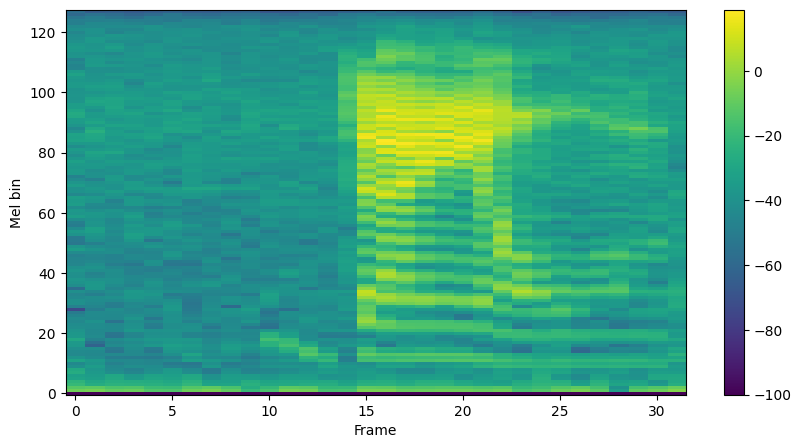

In [29]:
# TASK. MEL SPECTROGRAM
import torchaudio.transforms as T

#compute power spectrogram
power_spec = T.Spectrogram(n_fft=512, hop_length=512, win_length=512, power=2.0) #we consider only real values instead of complex --> will produce 256//2 + 1 bins
spec = power_spec(waveform)

#compute mel spectrogram
mel_scale = T.MelScale(n_mels=128, sample_rate=sample_rate, n_stft=512//2 + 1) #we consider only real values instead of complex
mel_spec = mel_scale(spec)

power_to_db = T.AmplitudeToDB()

#compute mel spectrogram in dB
dbmelspec = power_to_db(mel_spec)

print("Shape of spectrogram: {}".format(dbmelspec.shape))

plt.figure(figsize=(10,5))
plt.xlabel('Frame')
plt.ylabel('Mel bin')
plt.imshow(dbmelspec[0], origin="lower", aspect="auto", interpolation="nearest")
plt.colorbar()
plt.show()


## Formatting the data



Functions `label_to_index` and `index_to_label` are used to map (and encode) each word with its index in the list of labels.



In [30]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(0) --> yes


To turn a list of data point made of audio recordings and utterances into two batched tensors for the model, we implement a collate function which is used by the PyTorch DataLoader that allows us to iterate over a dataset by batches. Please see the documentation for more information about working with a [collate function](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn).

Each sequence is eventually padded with zeros so that tensors in a batch will have all the same length.


In [31]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch] #transpose: (1, 16000) → (16000, 1)
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1) #(batch_size, 1, 16000)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Generic functions for training and testing the network model

Now let’s define a *generic* training function that will feed our training data into the model and perform the backward pass and optimization steps. The network will then be tested after each epoch to see how the accuracy varies during the training.

The *generic* function receives as parameters:
* The **trasform** function to apply to the data (or `None`).
* The **criterion** function for computing the loss.
* The **optimizer** to be used during the process.

In [32]:
def train(model, transform, criterion, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        if transform != None :
          data = transform(data)
          
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        # loss = F.nll_loss(output.squeeze(), target)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print()
            print(f"       Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]")
            print(f"       Loss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)

        # record loss
        losses.append(loss.item())

Now that we have a *generic* training function, we need to make a *generic* one for testing the networks accuracy. We will set the model to `eval()` mode and then run inference on the test dataset. Calling `eval()` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.

In [33]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, transform, criterion, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        if transform != None :
          data = transform(data)

        output = model(data)
        loss = criterion(output, target)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)


    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Define a *generic* predictor end evaluate function to be used in the evaluation phase.

In [50]:
# Returns the predict function binded to the model and transform
def predictor(model, transform):

    def p(tensor):
      # Use the model to predict the label of the waveform
      tensor = tensor.to(device)
      tensor = transform(tensor)
      tensor = model(tensor.unsqueeze(0))
      tensor = get_likely_index(tensor)
      tensor = index_to_label(tensor.squeeze())
      return tensor

    return p


def evaluate(losses, predict, eval_set):

  # Let's plot the training loss versus the number of iteration.
  plt.plot(losses);
  plt.title("training loss");

  cnt = 0

  for i, (waveform, sample_rate, utterance, *_) in enumerate(eval_set):
      try:
          output = predict(waveform)
      except:
          output = None
          # print("An exception occurred ", utterance, output)
      if output != utterance:
          # ipd.Audio(waveform.numpy(), rate=sample_rate)
          # print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
          print('-', end="")
      else:
          print('*', end="")
          cnt = cnt + 1
      if(not((i+1) % 100)):
        print()

  return cnt/len(eval_set)

# Part I

## Mel spectrogram model (with 2D transformation)



**Task: Mel Spectrogram Transform.** Starting from the data visualization section where the Mel Spectrogram of a sample has been computed, build _transform pipeline_ to convert the audio samples to the Mel spectrogram representation.

* H: check the shape of the 2D array before using it as input to the model, i.e. the number of bins (values) both in the time and frequency domain.


In [67]:
from torchaudio.transforms import Resample, Spectrogram, MelScale, TimeStretch, FrequencyMasking, TimeMasking

class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        n_fft=1024,
        n_mel=256,
    ):
        super().__init__()

        self.spec = Spectrogram(n_fft=n_fft, hop_length=512, win_length=512, power=2)

        self.mel_scale = MelScale(
            n_mels=n_mel, sample_rate=input_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Convert to power spectrogram
        spec = self.spec(waveform)

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel

**Task. 2D Newtork Model.**  Define a convolutional neural network (CNN) starting from the architecture implemented in Lab n.03 for the fashion MINST dataset and adapting its structure to the data at hand.




In [68]:
NUM_CLASSES = 8
import torch.nn.functional as FU

In [72]:
## TASK. BUILD THE NETWORK MODEL

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)

        self.conv2 = nn.Conv2d(3, 6, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(6)


        self.conv3 = nn.Conv2d(6, 12, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(12)

        self.fcl1 = nn.Linear(12*32*8, 512)
        self.fcl2 = nn.Linear(512, 8)


        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = FU.relu(self.bn1(self.conv1(x)))

        x = self.pool(FU.relu(self.bn2(self.conv2(x))))

        x = self.pool(FU.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = FU.relu(self.fcl1(x))
        x = self.fcl2(x)

        return x



model_CNN = CNN()


transform_CNN = MyPipeline(input_freq=sample_rate, n_fft=512, n_mel=128)

criterion_CNN = nn.CrossEntropyLoss()
#optimizer_CNN = optim.Adam(model_CNN.parameters(), lr=0.01, weight_decay=0.001)

In [74]:
transform_CNN(waveform).shape

torch.Size([1, 128, 32])

### Training and testing

**Task.** Train and test the network model. _Assign to the model, transform, and criterion variables the classes or functions to be used for the specific model at hand._

* Q: Do the result change using the default MelSpectrogram transform or the customized one with different window, fft, and mel parameters?

* Repeat the processing, training and test the results. Consider changing the input representation, the network architecture, or the network hyper-parameters

* Plot the training loss versus the number of iterations.

* Look at the prediction performance and annotate the results for the comparison with the 1D model.

In [77]:
# UNCOMMENT and CUSTOMIZE with the proper model, transform and criterion (either for 1D or 2D networks)
model = model_CNN
transform = transform_CNN
criterion = criterion_CNN

log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
model = model.to(device)
transform = transform.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=n_epoch,
                                              anneal_strategy='linear')



print("Number of parameters: %s" % sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, transform, criterion, optimizer, epoch, log_interval)
        test(model, transform, criterion, epoch)
        scheduler.step()

Number of parameters: 1578380
CNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fcl1): Linear(in_features=3072, out_features=512, bias=True)
  (fcl2): Linear(in_features=512, out_features=8, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


  0%|          | 0/10 [00:00<?, ?it/s]


       Train Epoch: 1 [0/24713 (0%)]


  0%|          | 0.02727272727272727/10 [00:00<02:25, 14.55s/it]

       Loss: 1.625654


  2%|▏         | 0.20909090909090913/10 [00:01<01:10,  7.20s/it] 


       Train Epoch: 1 [5120/24713 (21%)]
       Loss: 1.744351


  4%|▍         | 0.390909090909091/10 [00:03<01:16,  7.91s/it]  


       Train Epoch: 1 [10240/24713 (41%)]
       Loss: 1.556237


  6%|▌         | 0.5727272727272724/10 [00:04<01:17,  8.27s/it] 


       Train Epoch: 1 [15360/24713 (62%)]
       Loss: 1.637178


  8%|▊         | 0.7545454545454532/10 [00:06<01:15,  8.21s/it]


       Train Epoch: 1 [20480/24713 (82%)]
       Loss: 1.741067


 10%|█         | 1.0090909090909064/10 [00:08<01:04,  7.13s/it]


Test Epoch: 1	Accuracy: 1557/3276 (48%)


       Train Epoch: 2 [0/24713 (0%)]
       Loss: 1.517053


 12%|█▏        | 1.2090909090909052/10 [00:09<01:20,  9.18s/it]


       Train Epoch: 2 [5120/24713 (21%)]
       Loss: 1.548628


 14%|█▍        | 1.390909090909086/10 [00:11<01:18,  9.09s/it] 


       Train Epoch: 2 [10240/24713 (41%)]
       Loss: 1.564021


 16%|█▌        | 1.5727272727272668/10 [00:13<01:16,  9.09s/it]


       Train Epoch: 2 [15360/24713 (62%)]
       Loss: 1.490629


 18%|█▊        | 1.7545454545454475/10 [00:14<01:13,  8.97s/it]


       Train Epoch: 2 [20480/24713 (82%)]
       Loss: 1.503866


 20%|██        | 2.009090909090901/10 [00:16<00:56,  7.09s/it] 


Test Epoch: 2	Accuracy: 1649/3276 (50%)


       Train Epoch: 3 [0/24713 (0%)]
       Loss: 1.599894


 22%|██▏       | 2.2090909090909046/10 [00:18<01:11,  9.14s/it]


       Train Epoch: 3 [5120/24713 (21%)]
       Loss: 1.553015


 24%|██▍       | 2.3909090909090898/10 [00:20<01:09,  9.08s/it]


       Train Epoch: 3 [10240/24713 (41%)]
       Loss: 1.549533


 26%|██▌       | 2.572727272727275/10 [00:22<01:06,  8.95s/it] 


       Train Epoch: 3 [15360/24713 (62%)]
       Loss: 1.452930


 28%|██▊       | 2.75454545454546/10 [00:23<01:02,  8.67s/it]  


       Train Epoch: 3 [20480/24713 (82%)]
       Loss: 1.470195


 30%|███       | 3.0090909090909195/10 [00:25<00:53,  7.61s/it]


Test Epoch: 3	Accuracy: 1650/3276 (50%)


       Train Epoch: 4 [0/24713 (0%)]
       Loss: 1.431612


 32%|███▏      | 3.209090909090923/10 [00:27<01:00,  8.94s/it] 


       Train Epoch: 4 [5120/24713 (21%)]
       Loss: 1.405203


 34%|███▍      | 3.3909090909091084/10 [00:29<00:59,  8.93s/it]


       Train Epoch: 4 [10240/24713 (41%)]
       Loss: 1.522012


 36%|███▌      | 3.5727272727272936/10 [00:31<00:59,  9.20s/it]


       Train Epoch: 4 [15360/24713 (62%)]
       Loss: 1.398798


 38%|███▊      | 3.754545454545479/10 [00:32<00:54,  8.71s/it] 


       Train Epoch: 4 [20480/24713 (82%)]
       Loss: 1.263880


 40%|████      | 4.009090909090937/10 [00:34<00:44,  7.47s/it] 


Test Epoch: 4	Accuracy: 1719/3276 (52%)


       Train Epoch: 5 [0/24713 (0%)]
       Loss: 1.320318


 42%|████▏     | 4.209090909090931/10 [00:36<00:53,  9.18s/it] 


       Train Epoch: 5 [5120/24713 (21%)]
       Loss: 1.333231


 44%|████▍     | 4.3909090909091075/10 [00:38<00:51,  9.12s/it]


       Train Epoch: 5 [10240/24713 (41%)]
       Loss: 1.537223


 46%|████▌     | 4.572727272727284/10 [00:39<00:48,  8.96s/it] 


       Train Epoch: 5 [15360/24713 (62%)]
       Loss: 1.364203


 48%|████▊     | 4.75454545454546/10 [00:41<00:47,  9.13s/it]  


       Train Epoch: 5 [20480/24713 (82%)]
       Loss: 1.440360


 50%|█████     | 5.009090909090907/10 [00:43<00:39,  7.85s/it] 


Test Epoch: 5	Accuracy: 1813/3276 (55%)


       Train Epoch: 6 [0/24713 (0%)]
       Loss: 1.432960


 52%|█████▏    | 5.209090909090901/10 [00:45<00:45,  9.42s/it] 


       Train Epoch: 6 [5120/24713 (21%)]
       Loss: 1.444284


 54%|█████▍    | 5.390909090909077/10 [00:47<00:40,  8.74s/it] 


       Train Epoch: 6 [10240/24713 (41%)]
       Loss: 1.330397


 56%|█████▌    | 5.572727272727254/10 [00:48<00:39,  8.93s/it] 


       Train Epoch: 6 [15360/24713 (62%)]
       Loss: 1.313497


 58%|█████▊    | 5.75454545454543/10 [00:50<00:37,  8.90s/it]  


       Train Epoch: 6 [20480/24713 (82%)]
       Loss: 1.256644


 60%|██████    | 6.009090909090877/10 [00:52<00:27,  6.88s/it] 


Test Epoch: 6	Accuracy: 1873/3276 (57%)


       Train Epoch: 7 [0/24713 (0%)]
       Loss: 1.292406


 62%|██████▏   | 6.209090909090871/10 [00:54<00:35,  9.36s/it] 


       Train Epoch: 7 [5120/24713 (21%)]
       Loss: 1.113487


 64%|██████▍   | 6.390909090909047/10 [00:56<00:33,  9.27s/it] 


       Train Epoch: 7 [10240/24713 (41%)]
       Loss: 1.207226


 66%|██████▌   | 6.5727272727272235/10 [00:57<00:32,  9.41s/it]


       Train Epoch: 7 [15360/24713 (62%)]
       Loss: 1.340841


 68%|██████▊   | 6.7545454545454/10 [00:59<00:30,  9.29s/it]   


       Train Epoch: 7 [20480/24713 (82%)]
       Loss: 1.262906


 70%|███████   | 7.009090909090847/10 [01:01<00:22,  7.68s/it] 


Test Epoch: 7	Accuracy: 1936/3276 (59%)


       Train Epoch: 8 [0/24713 (0%)]
       Loss: 1.192122


 72%|███████▏  | 7.209090909090841/10 [01:03<00:27,  9.81s/it] 


       Train Epoch: 8 [5120/24713 (21%)]
       Loss: 1.170234


 74%|███████▍  | 7.390909090909017/10 [01:05<00:23,  9.01s/it] 


       Train Epoch: 8 [10240/24713 (41%)]
       Loss: 1.236253


 76%|███████▌  | 7.572727272727193/10 [01:07<00:23,  9.88s/it] 


       Train Epoch: 8 [15360/24713 (62%)]
       Loss: 1.071675


 78%|███████▊  | 7.75454545454537/10 [01:08<00:19,  8.80s/it]  


       Train Epoch: 8 [20480/24713 (82%)]
       Loss: 1.081329


 80%|████████  | 8.009090909090817/10 [01:10<00:14,  7.05s/it] 


Test Epoch: 8	Accuracy: 1985/3276 (61%)


       Train Epoch: 9 [0/24713 (0%)]
       Loss: 1.072585


 82%|████████▏ | 8.20909090909083/10 [01:12<00:16,  9.21s/it] 


       Train Epoch: 9 [5120/24713 (21%)]
       Loss: 1.063769


 84%|████████▍ | 8.390909090909025/10 [01:14<00:14,  8.90s/it]


       Train Epoch: 9 [10240/24713 (41%)]
       Loss: 1.121098


 86%|████████▌ | 8.572727272727219/10 [01:15<00:12,  8.77s/it]


       Train Epoch: 9 [15360/24713 (62%)]
       Loss: 1.057946


 88%|████████▊ | 8.754545454545413/10 [01:17<00:11,  9.11s/it]


       Train Epoch: 9 [20480/24713 (82%)]
       Loss: 1.022051


 90%|█████████ | 9.009090909090885/10 [01:19<00:07,  7.16s/it]


Test Epoch: 9	Accuracy: 2026/3276 (62%)


       Train Epoch: 10 [0/24713 (0%)]
       Loss: 0.950465


 92%|█████████▏| 9.209090909090898/10 [01:21<00:07,  8.85s/it]


       Train Epoch: 10 [5120/24713 (21%)]
       Loss: 1.000703


 94%|█████████▍| 9.390909090909092/10 [01:23<00:05,  8.59s/it]


       Train Epoch: 10 [10240/24713 (41%)]
       Loss: 1.100224


 96%|█████████▌| 9.572727272727287/10 [01:24<00:03,  8.61s/it]


       Train Epoch: 10 [15360/24713 (62%)]
       Loss: 1.042382


 98%|█████████▊| 9.75454545454548/10 [01:26<00:02,  8.83s/it] 


       Train Epoch: 10 [20480/24713 (82%)]
       Loss: 1.036415


100%|█████████▉| 9.990909090909133/10 [01:28<00:00,  6.87s/it]c:\Users\Utente\OneDrive - Politecnico di Torino\Universita\Magistrale\Secondo Anno\MachineLearning_for_Vision_and_Multimedia\LABS\venv\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 10.000000000000043/10 [01:28<00:00,  8.82s/it]


Test Epoch: 10	Accuracy: 2081/3276 (64%)




--**-*---**--**-*-*-**---****---***-----****-**-**-*-**--*--**-****-*--*-*--*---**-**-**-----*-*--**
-**--*--*--*---*-***-*----*--*******-**--**-*-**-****-***--*-*-***-*-*--**-***-**------*-**--******-
--**--*--*-***---**-*-**---**-------*-*-------***--*-***-*-*-**-*-***--*-*--*---*-**-*-*-*--*---*--*
***--*--*-*****---*-*---****---------****-**-****-*-*----*--***----*-*-------*--*---*-*-*---*-*--*-*
---*--**------**---**------*-**-**--*****----**-----***--*---**-*--*---*******-**---**-*-*-*--**-*--
**--**-***-*--*-*---*-***--**-*-**---*--*--*----*****-**--**-----*-*--***--*-**--**-------*---*--*-*
*-----***--------*----**-----*-------**---*-*--**-****-----***-****-***-*-**----**--*****-******-***
*-*-***-*-*-*******--*----************--***------*-----*****--*-*---*-----**--*--******-*-**-***---*
-**---*--***---****--*---*-*--***-*--*----**----*-***-----*-**--*-*-**-*-*******-*---****-*-**--*-**
---**-****--*-*****---**--*---*--**-*-**--*****-----*---**-----*--*--**--*------***-*--*--

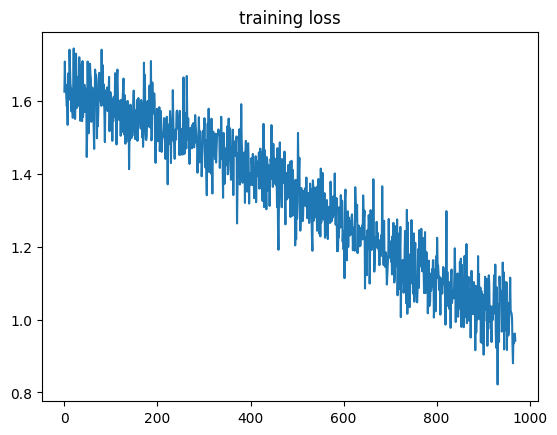

In [78]:
# Evaluate on the validation set
predict = predictor(model, transform)
print()
perc = evaluate(losses, predict, valid_set)
print()
print("Validation set prediction accuracy: ", perc)


# Part II

## End-to-end model (i.e., no data processing)

As a first example we will use **the raw audio data** and a 1D convolutional neural network. Usually more advanced transforms are applied to the audio data, however CNNs can also be used to process the raw data.

**Task.** Build a network model with architecture defined as M5 in the paper [Very deep convolutional neural networks for raw waveforms](https://arxiv.org/pdf/1610.00087.pdf).

An important aspect of models processing raw audio data is the receptive field of their first layer’s filters. This model’s first filter is length 80 so when processing audio sampled at 8kHz the receptive field is around 10ms (and at 4kHz, around 20 ms). This size is similar to speech processing applications that often use receptive fields ranging from 20ms to 40ms.

![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/d00e2d2e3c00b96c68be26d3ee3c2deaec106868/m5-model.small.jpg)

Here is a model example.
```
M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=8, bias=True)
)
```

**Task.** For the waveform, we define a **transform function** to downsample the audio (see `torchaudio.transforms.Resample`) for faster processing without losing too much of the classification power.
* Q: Which _reduced_ sample rate can be used to preserve speech information?
    - For AUDIO: **22kHz**
    - For VOICE: **8Khz**

We don’t need to apply other transformations here. It is common for some datasets though to have to reduce the number of channels (say from stereo to mono) by either taking the mean along the channel dimension, or simply keeping only one of the channels. Since SpeechCommands uses a single channel for audio, this is not needed here.

In [111]:
class MyPipelineM5(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq = 8000,
    ):
        super().__init__()

        self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample
        resampled = self.resample(waveform)
        return resampled

In [112]:
class M5(nn.Module):
    def __init__(self):
        super(M5, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=(80,), stride=(16,))
        self.bn1 = nn.BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        self.bn2 = nn.BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=(3,), stride=(1,))
        self.bn3 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        self.bn4 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool4 = nn.MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        self.fc1 =nn.Linear(in_features=64, out_features=8, bias=True)

    def forward(self, x):
        x = self.pool1(self.bn1(self.conv1(x)))
        x = self.pool2(self.bn2(self.conv2(x)))
        x = self.pool3(self.bn3(self.conv3(x)))
        x = self.pool4(self.bn4(self.conv4(x)))
        x = x.mean(dim=2)  # Global average pooling for each channel --> (64,)
        x = self.fc1(x)
        return x
        



In [113]:
    
model_M5 = M5()

transform_M5 = MyPipelineM5()

#criterion_M5 = lambda o,t: nn.NLLLoss()(o.squeeze(),t)
criterion_M5 = nn.CrossEntropyLoss()


### Training and testing

Finally, we can train and test the network. The network will be tested after each epoch to see how the accuracy varies during the training.

The network should be more than 65% accurate on the test set after 2 epochs, and 85% after 21 epochs.

Note. We will use the same optimization technique used in the paper, an Adam optimizer with weight decay set to 0.0001. If the number of epoch is greater than 20, an optimizer can be added in order to decrease the weight decay.

**Task.** Train and test the network model. Assign to the `model`, `transform`, and `criterion` variables the classes or functions to be used for the specific model at hand.   




In [108]:
# CUSTOMIZE with the proper model, transform and criterion (either for 1D or 2D networks)
model = model_M5
transform = transform_M5
criterion = criterion_M5

log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
model = model.to(device)
transform = transform.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
## At first, we will train with a learning rate of 0.01, but we will use a scheduler to decrease it to 0.001 during training after 20 epochs.
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


print("Number of parameters: %s" % sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, transform, criterion, optimizer, epoch, log_interval)
        test(model, transform, criterion, epoch)
#        scheduler.step()


Number of parameters: 25160
M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_fea

  1%|          | 0.01818181818181818/2 [00:00<00:18,  9.58s/it]


       Train Epoch: 1 [0/24713 (0%)]
       Loss: 2.141745


 11%|█         | 0.21818181818181823/2 [00:01<00:13,  7.61s/it]


       Train Epoch: 1 [5120/24713 (21%)]
       Loss: 1.839120


 19%|█▉        | 0.3818181818181819/2 [00:03<00:14,  8.80s/it] 


       Train Epoch: 1 [10240/24713 (41%)]
       Loss: 1.650035


 28%|██▊       | 0.5636363636363634/2 [00:04<00:10,  7.53s/it] 


       Train Epoch: 1 [15360/24713 (62%)]
       Loss: 1.428313


 37%|███▋      | 0.7454545454545441/2 [00:06<00:09,  7.89s/it]


       Train Epoch: 1 [20480/24713 (82%)]
       Loss: 1.390658


 51%|█████     | 1.0181818181818154/2 [00:08<00:07,  8.03s/it]


Test Epoch: 1	Accuracy: 1873/3276 (57%)


       Train Epoch: 2 [0/24713 (0%)]
       Loss: 1.320975


 61%|██████    | 1.2181818181818143/2 [00:09<00:05,  7.43s/it]


       Train Epoch: 2 [5120/24713 (21%)]
       Loss: 1.306055


 69%|██████▉   | 1.381818181818177/2 [00:10<00:04,  7.67s/it] 


       Train Epoch: 2 [10240/24713 (41%)]
       Loss: 1.188459


 78%|███████▊  | 1.5636363636363577/2 [00:12<00:03,  7.64s/it]


       Train Epoch: 2 [15360/24713 (62%)]
       Loss: 1.158388


 87%|████████▋ | 1.7454545454545385/2 [00:13<00:01,  7.61s/it]


       Train Epoch: 2 [20480/24713 (82%)]
       Loss: 1.065745


100%|█████████▉| 1.9999999999999916/2 [00:15<00:00,  7.84s/it]


Test Epoch: 2	Accuracy: 2199/3276 (67%)



In [114]:
#rerun previous cells to reinitializate the followings:
model = model_M5
transform = transform_M5
criterion = criterion_M5

#then:

log_interval = 20
n_epoch = 21

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
model = model.to(device)
transform = transform.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10


print("Number of parameters: %s" % sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, transform, criterion, optimizer, epoch, log_interval)
        test(model, transform, criterion, epoch)
        scheduler.step()


Number of parameters: 25160
M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_fea

  0%|          | 0.00909090909090909/21 [00:00<04:25, 12.63s/it]


       Train Epoch: 1 [0/24713 (0%)]
       Loss: 2.231615


  1%|          | 0.19090909090909094/21 [00:01<03:31, 10.14s/it] 


       Train Epoch: 1 [5120/24713 (21%)]
       Loss: 1.514735


  2%|▏         | 0.390909090909091/21 [00:03<02:59,  8.70s/it]  


       Train Epoch: 1 [10240/24713 (41%)]
       Loss: 1.282395


  3%|▎         | 0.5727272727272724/21 [00:05<02:44,  8.07s/it] 


       Train Epoch: 1 [15360/24713 (62%)]
       Loss: 1.128598


  4%|▎         | 0.7545454545454532/21 [00:07<03:20,  9.90s/it]


       Train Epoch: 1 [20480/24713 (82%)]
       Loss: 0.964434


  5%|▍         | 1.0272727272727245/21 [00:09<02:22,  7.14s/it]


Test Epoch: 1	Accuracy: 2054/3276 (63%)


       Train Epoch: 2 [0/24713 (0%)]
       Loss: 0.954043


  6%|▌         | 1.2090909090909052/21 [00:10<02:35,  7.86s/it]


       Train Epoch: 2 [5120/24713 (21%)]
       Loss: 0.951932


  7%|▋         | 1.390909090909086/21 [00:12<02:33,  7.83s/it] 


       Train Epoch: 2 [10240/24713 (41%)]
       Loss: 0.929937


  7%|▋         | 1.5727272727272668/21 [00:13<02:54,  8.96s/it]


       Train Epoch: 2 [15360/24713 (62%)]
       Loss: 1.068679


  8%|▊         | 1.7545454545454475/21 [00:15<02:22,  7.41s/it]


       Train Epoch: 2 [20480/24713 (82%)]
       Loss: 0.922240


 10%|▉         | 2.009090909090901/21 [00:17<02:32,  8.05s/it] 


Test Epoch: 2	Accuracy: 2290/3276 (70%)


       Train Epoch: 3 [0/24713 (0%)]
       Loss: 0.853266


 11%|█         | 2.2090909090909046/21 [00:19<02:43,  8.72s/it]


       Train Epoch: 3 [5120/24713 (21%)]
       Loss: 0.887992


 11%|█▏        | 2.3909090909090898/21 [00:20<02:30,  8.09s/it]


       Train Epoch: 3 [10240/24713 (41%)]
       Loss: 0.790933


 12%|█▏        | 2.572727272727275/21 [00:21<02:13,  7.23s/it] 


       Train Epoch: 3 [15360/24713 (62%)]
       Loss: 0.828733


 13%|█▎        | 2.75454545454546/21 [00:23<02:30,  8.26s/it]  


       Train Epoch: 3 [20480/24713 (82%)]
       Loss: 0.736013


 14%|█▍        | 3.0090909090909195/21 [00:25<02:04,  6.91s/it]


Test Epoch: 3	Accuracy: 2482/3276 (76%)


       Train Epoch: 4 [0/24713 (0%)]
       Loss: 0.751973


 15%|█▌        | 3.209090909090923/21 [00:27<02:24,  8.14s/it] 


       Train Epoch: 4 [5120/24713 (21%)]
       Loss: 0.819555


 16%|█▌        | 3.3909090909091084/21 [00:28<02:08,  7.29s/it]


       Train Epoch: 4 [10240/24713 (41%)]
       Loss: 0.716322


 17%|█▋        | 3.5727272727272936/21 [00:29<02:32,  8.73s/it]


       Train Epoch: 4 [15360/24713 (62%)]
       Loss: 0.685870


 18%|█▊        | 3.754545454545479/21 [00:31<02:29,  8.66s/it] 


       Train Epoch: 4 [20480/24713 (82%)]
       Loss: 0.741837


 19%|█▉        | 4.009090909090937/21 [00:33<02:15,  7.98s/it] 


Test Epoch: 4	Accuracy: 2554/3276 (78%)


       Train Epoch: 5 [0/24713 (0%)]
       Loss: 0.807615


 20%|██        | 4.209090909090931/21 [00:35<02:10,  7.78s/it] 


       Train Epoch: 5 [5120/24713 (21%)]
       Loss: 0.579715


 21%|██        | 4.3909090909091075/21 [00:36<02:00,  7.23s/it]


       Train Epoch: 5 [10240/24713 (41%)]
       Loss: 0.589715


 22%|██▏       | 4.572727272727284/21 [00:38<02:26,  8.93s/it] 


       Train Epoch: 5 [15360/24713 (62%)]
       Loss: 0.526933


 23%|██▎       | 4.75454545454546/21 [00:39<02:05,  7.74s/it]  


       Train Epoch: 5 [20480/24713 (82%)]
       Loss: 0.642102


 24%|██▍       | 5.009090909090907/21 [00:41<02:01,  7.62s/it] 


Test Epoch: 5	Accuracy: 2575/3276 (79%)


       Train Epoch: 6 [0/24713 (0%)]
       Loss: 0.590078


 25%|██▍       | 5.209090909090901/21 [00:43<02:22,  9.03s/it] 


       Train Epoch: 6 [5120/24713 (21%)]
       Loss: 0.603932


 26%|██▌       | 5.390909090909077/21 [00:45<02:18,  8.90s/it] 


       Train Epoch: 6 [10240/24713 (41%)]
       Loss: 0.623238


 27%|██▋       | 5.572727272727254/21 [00:46<01:50,  7.19s/it] 


       Train Epoch: 6 [15360/24713 (62%)]
       Loss: 0.745032


 27%|██▋       | 5.75454545454543/21 [00:47<02:07,  8.39s/it]  


       Train Epoch: 6 [20480/24713 (82%)]
       Loss: 0.609860


 29%|██▊       | 6.009090909090877/21 [00:49<01:43,  6.89s/it] 


Test Epoch: 6	Accuracy: 2632/3276 (80%)


       Train Epoch: 7 [0/24713 (0%)]
       Loss: 0.619326


 30%|██▉       | 6.209090909090871/21 [00:51<02:08,  8.70s/it] 


       Train Epoch: 7 [5120/24713 (21%)]
       Loss: 0.477127


 30%|███       | 6.390909090909047/21 [00:52<01:49,  7.51s/it] 


       Train Epoch: 7 [10240/24713 (41%)]
       Loss: 0.608353


 31%|███▏      | 6.5727272727272235/21 [00:54<02:07,  8.87s/it]


       Train Epoch: 7 [15360/24713 (62%)]
       Loss: 0.519873


 32%|███▏      | 6.7545454545454/21 [00:55<02:04,  8.74s/it]   


       Train Epoch: 7 [20480/24713 (82%)]
       Loss: 0.559995


 33%|███▎      | 7.009090909090847/21 [00:57<01:34,  6.76s/it] 


Test Epoch: 7	Accuracy: 2626/3276 (80%)


       Train Epoch: 8 [0/24713 (0%)]
       Loss: 0.495793


 34%|███▍      | 7.209090909090841/21 [00:59<01:58,  8.61s/it] 


       Train Epoch: 8 [5120/24713 (21%)]
       Loss: 0.446216


 35%|███▌      | 7.390909090909017/21 [01:01<01:53,  8.36s/it] 


       Train Epoch: 8 [10240/24713 (41%)]
       Loss: 0.449692


 36%|███▌      | 7.572727272727193/21 [01:02<01:38,  7.34s/it] 


       Train Epoch: 8 [15360/24713 (62%)]
       Loss: 0.459517


 37%|███▋      | 7.75454545454537/21 [01:03<01:52,  8.52s/it]  


       Train Epoch: 8 [20480/24713 (82%)]
       Loss: 0.549793


 38%|███▊      | 8.009090909090817/21 [01:05<01:25,  6.59s/it] 


Test Epoch: 8	Accuracy: 2651/3276 (81%)


       Train Epoch: 9 [0/24713 (0%)]
       Loss: 0.557093


 39%|███▉      | 8.20909090909083/21 [01:07<01:54,  8.97s/it] 


       Train Epoch: 9 [5120/24713 (21%)]
       Loss: 0.483419


 40%|███▉      | 8.390909090909025/21 [01:08<01:50,  8.76s/it]


       Train Epoch: 9 [10240/24713 (41%)]
       Loss: 0.458816


 41%|████      | 8.572727272727219/21 [01:10<01:30,  7.31s/it]


       Train Epoch: 9 [15360/24713 (62%)]
       Loss: 0.439402


 42%|████▏     | 8.754545454545413/21 [01:11<01:45,  8.64s/it]


       Train Epoch: 9 [20480/24713 (82%)]
       Loss: 0.492628


 43%|████▎     | 9.009090909090885/21 [01:13<01:19,  6.65s/it]


Test Epoch: 9	Accuracy: 2705/3276 (83%)


       Train Epoch: 10 [0/24713 (0%)]
       Loss: 0.381179


 44%|████▍     | 9.209090909090898/21 [01:15<01:43,  8.74s/it]


       Train Epoch: 10 [5120/24713 (21%)]
       Loss: 0.547109


 45%|████▍     | 9.390909090909092/21 [01:16<01:24,  7.30s/it]


       Train Epoch: 10 [10240/24713 (41%)]
       Loss: 0.624435


 46%|████▌     | 9.572727272727287/21 [01:18<01:40,  8.83s/it]


       Train Epoch: 10 [15360/24713 (62%)]
       Loss: 0.485650


 46%|████▋     | 9.75454545454548/21 [01:19<01:27,  7.79s/it] 


       Train Epoch: 10 [20480/24713 (82%)]
       Loss: 0.597330


 48%|████▊     | 10.009090909090952/21 [01:21<01:22,  7.51s/it]


Test Epoch: 10	Accuracy: 2609/3276 (80%)


       Train Epoch: 11 [0/24713 (0%)]
       Loss: 0.522210


 49%|████▊     | 10.209090909090966/21 [01:23<01:21,  7.51s/it]


       Train Epoch: 11 [5120/24713 (21%)]
       Loss: 0.446732


 49%|████▉     | 10.39090909090916/21 [01:24<01:23,  7.89s/it] 


       Train Epoch: 11 [10240/24713 (41%)]
       Loss: 0.342204


 50%|█████     | 10.572727272727354/21 [01:26<01:22,  7.87s/it]


       Train Epoch: 11 [15360/24713 (62%)]
       Loss: 0.469922


 51%|█████     | 10.754545454545548/21 [01:27<01:13,  7.15s/it]


       Train Epoch: 11 [20480/24713 (82%)]
       Loss: 0.504628


 52%|█████▏    | 11.00909090909102/21 [01:29<01:17,  7.79s/it] 


Test Epoch: 11	Accuracy: 2725/3276 (83%)


       Train Epoch: 12 [0/24713 (0%)]
       Loss: 0.351500


 53%|█████▎    | 11.209090909091033/21 [01:31<01:11,  7.31s/it]


       Train Epoch: 12 [5120/24713 (21%)]
       Loss: 0.402486


 54%|█████▍    | 11.390909090909227/21 [01:32<01:21,  8.49s/it]


       Train Epoch: 12 [10240/24713 (41%)]
       Loss: 0.389439


 55%|█████▌    | 11.572727272727422/21 [01:34<01:23,  8.81s/it]


       Train Epoch: 12 [15360/24713 (62%)]
       Loss: 0.362578


 56%|█████▌    | 11.754545454545616/21 [01:35<01:08,  7.45s/it]


       Train Epoch: 12 [20480/24713 (82%)]
       Loss: 0.425528


 57%|█████▋    | 12.009090909091087/21 [01:37<01:07,  7.54s/it]


Test Epoch: 12	Accuracy: 2729/3276 (83%)


       Train Epoch: 13 [0/24713 (0%)]
       Loss: 0.491969


 58%|█████▊    | 12.2090909090911/21 [01:39<01:16,  8.65s/it]  


       Train Epoch: 13 [5120/24713 (21%)]
       Loss: 0.391477


 59%|█████▉    | 12.390909090909295/21 [01:40<01:03,  7.36s/it]


       Train Epoch: 13 [10240/24713 (41%)]
       Loss: 0.403983


 60%|█████▉    | 12.572727272727489/21 [01:42<01:13,  8.67s/it]


       Train Epoch: 13 [15360/24713 (62%)]
       Loss: 0.389471


 61%|██████    | 12.754545454545683/21 [01:43<01:07,  8.24s/it]


       Train Epoch: 13 [20480/24713 (82%)]
       Loss: 0.446129


 62%|██████▏   | 13.009090909091155/21 [01:45<00:57,  7.21s/it]


Test Epoch: 13	Accuracy: 2631/3276 (80%)


       Train Epoch: 14 [0/24713 (0%)]
       Loss: 0.408997


 63%|██████▎   | 13.209090909091168/21 [01:47<01:11,  9.15s/it]


       Train Epoch: 14 [5120/24713 (21%)]
       Loss: 0.397878


 64%|██████▍   | 13.390909090909362/21 [01:48<00:56,  7.44s/it]


       Train Epoch: 14 [10240/24713 (41%)]
       Loss: 0.572566


 65%|██████▍   | 13.572727272727557/21 [01:50<01:03,  8.58s/it]


       Train Epoch: 14 [15360/24713 (62%)]
       Loss: 0.484450


 65%|██████▌   | 13.75454545454575/21 [01:51<00:53,  7.33s/it] 


       Train Epoch: 14 [20480/24713 (82%)]
       Loss: 0.432778


 67%|██████▋   | 14.009090909091222/21 [01:53<00:54,  7.76s/it]


Test Epoch: 14	Accuracy: 2675/3276 (82%)


       Train Epoch: 15 [0/24713 (0%)]
       Loss: 0.417541


 68%|██████▊   | 14.209090909091236/21 [01:55<00:50,  7.46s/it]


       Train Epoch: 15 [5120/24713 (21%)]
       Loss: 0.297293


 69%|██████▊   | 14.39090909090943/21 [01:56<00:56,  8.62s/it] 


       Train Epoch: 15 [10240/24713 (41%)]
       Loss: 0.367532


 69%|██████▉   | 14.572727272727624/21 [01:58<00:50,  7.80s/it]


       Train Epoch: 15 [15360/24713 (62%)]
       Loss: 0.314353


 70%|███████   | 14.754545454545818/21 [01:59<00:48,  7.81s/it]


       Train Epoch: 15 [20480/24713 (82%)]
       Loss: 0.494390


 71%|███████▏  | 15.00909090909129/21 [02:01<00:47,  7.94s/it] 


Test Epoch: 15	Accuracy: 2677/3276 (82%)


       Train Epoch: 16 [0/24713 (0%)]
       Loss: 0.326630


 72%|███████▏  | 15.209090909091303/21 [02:03<00:40,  7.08s/it]


       Train Epoch: 16 [5120/24713 (21%)]
       Loss: 0.353596


 73%|███████▎  | 15.390909090909497/21 [02:04<00:49,  8.79s/it]


       Train Epoch: 16 [10240/24713 (41%)]
       Loss: 0.268128


 74%|███████▍  | 15.572727272727692/21 [02:06<00:40,  7.41s/it]


       Train Epoch: 16 [15360/24713 (62%)]
       Loss: 0.362194


 75%|███████▌  | 15.754545454545886/21 [02:07<00:44,  8.56s/it]


       Train Epoch: 16 [20480/24713 (82%)]
       Loss: 0.430844


 76%|███████▌  | 16.009090909091356/21 [02:09<00:33,  6.71s/it]


Test Epoch: 16	Accuracy: 2744/3276 (84%)


       Train Epoch: 17 [0/24713 (0%)]
       Loss: 0.329585


 77%|███████▋  | 16.20909090909133/21 [02:11<00:40,  8.52s/it] 


       Train Epoch: 17 [5120/24713 (21%)]
       Loss: 0.387789


 78%|███████▊  | 16.39090909090949/21 [02:12<00:35,  7.69s/it] 


       Train Epoch: 17 [10240/24713 (41%)]
       Loss: 0.301869


 79%|███████▉  | 16.572727272727647/21 [02:14<00:38,  8.74s/it]


       Train Epoch: 17 [15360/24713 (62%)]
       Loss: 0.475191


 80%|███████▉  | 16.754545454545806/21 [02:15<00:32,  7.55s/it]


       Train Epoch: 17 [20480/24713 (82%)]
       Loss: 0.362066


 81%|████████  | 17.009090909091228/21 [02:17<00:30,  7.72s/it]


Test Epoch: 17	Accuracy: 2737/3276 (84%)


       Train Epoch: 18 [0/24713 (0%)]
       Loss: 0.459777


 82%|████████▏ | 17.209090909091202/21 [02:19<00:31,  8.36s/it]


       Train Epoch: 18 [5120/24713 (21%)]
       Loss: 0.332393


 83%|████████▎ | 17.39090909090936/21 [02:20<00:26,  7.22s/it] 


       Train Epoch: 18 [10240/24713 (41%)]
       Loss: 0.435844


 84%|████████▎ | 17.57272727272752/21 [02:22<00:30,  8.82s/it] 


       Train Epoch: 18 [15360/24713 (62%)]
       Loss: 0.359626


 85%|████████▍ | 17.754545454545678/21 [02:23<00:23,  7.37s/it]


       Train Epoch: 18 [20480/24713 (82%)]
       Loss: 0.499745


 86%|████████▌ | 18.0090909090911/21 [02:25<00:23,  7.91s/it]  


Test Epoch: 18	Accuracy: 2700/3276 (82%)


       Train Epoch: 19 [0/24713 (0%)]
       Loss: 0.397451


 87%|████████▋ | 18.209090909091074/21 [02:27<00:20,  7.34s/it]


       Train Epoch: 19 [5120/24713 (21%)]
       Loss: 0.347762


 88%|████████▊ | 18.390909090909233/21 [02:28<00:21,  8.34s/it]


       Train Epoch: 19 [10240/24713 (41%)]
       Loss: 0.319359


 88%|████████▊ | 18.57272727272739/21 [02:30<00:17,  7.31s/it] 


       Train Epoch: 19 [15360/24713 (62%)]
       Loss: 0.451300


 89%|████████▉ | 18.75454545454555/21 [02:31<00:19,  8.88s/it] 


       Train Epoch: 19 [20480/24713 (82%)]
       Loss: 0.387475


 91%|█████████ | 19.027272727272788/21 [02:33<00:13,  6.61s/it]


Test Epoch: 19	Accuracy: 2711/3276 (83%)


       Train Epoch: 20 [0/24713 (0%)]
       Loss: 0.200422


 91%|█████████▏| 19.209090909090946/21 [02:35<00:16,  8.98s/it]


       Train Epoch: 20 [5120/24713 (21%)]
       Loss: 0.255064


 92%|█████████▏| 19.390909090909105/21 [02:36<00:11,  7.26s/it]


       Train Epoch: 20 [10240/24713 (41%)]
       Loss: 0.370404


 93%|█████████▎| 19.572727272727263/21 [02:38<00:12,  8.62s/it]


       Train Epoch: 20 [15360/24713 (62%)]
       Loss: 0.315302


 94%|█████████▍| 19.754545454545422/21 [02:39<00:09,  7.52s/it]


       Train Epoch: 20 [20480/24713 (82%)]
       Loss: 0.315551


 95%|█████████▌| 20.009090909090844/21 [02:41<00:08,  8.08s/it]


Test Epoch: 20	Accuracy: 2690/3276 (82%)


       Train Epoch: 21 [0/24713 (0%)]
       Loss: 0.253181


 96%|█████████▌| 20.20909090909082/21 [02:43<00:06,  8.81s/it] 


       Train Epoch: 21 [5120/24713 (21%)]
       Loss: 0.302124


 97%|█████████▋| 20.390909090908977/21 [02:44<00:04,  7.35s/it]


       Train Epoch: 21 [10240/24713 (41%)]
       Loss: 0.253535


 98%|█████████▊| 20.572727272727136/21 [02:46<00:03,  8.81s/it]


       Train Epoch: 21 [15360/24713 (62%)]
       Loss: 0.237258


 99%|█████████▉| 20.754545454545294/21 [02:47<00:01,  7.30s/it]


       Train Epoch: 21 [20480/24713 (82%)]
       Loss: 0.204471


100%|█████████▉| 20.999999999999808/21 [02:49<00:00,  8.07s/it]


Test Epoch: 21	Accuracy: 2818/3276 (86%)



### Evaluate the model.

* Plot the training loss versus the number of iterations

* Look at the samples in the validation set and see how the model performs on it



***********-**********-******-*-******-*****-*************-********-****-*-*******-*****-***********
-***-*************-**************-**-***-**-******************-*-*****-***-********-***************-
****-*****-***-*-****-**-****-***-***-*-****-*************************-***-***-***************-*****
****-**************-*-************-*******************-****-***-*-******----*******-*--****-*-*-****
*-**--***--*---**********-********-*****************-**-****-**-**-***-************-**--**-**-****-*
*******************-***********-***-******-**--********-***-****-********-**-***-*****-**-*-***-****
***************-***-***-*-*-**-**--**********-***-*****-*-****************--*--**-*******-***-***---
-**********-********-**-************-******-*-*-*************-*****--***-***-**********-***-****-***
***--**--**-****-**--*-*****-****-*****-*****-*******************-******-***********-************-**
-*-********-*-*****-****-**-*********-***-*-****-**-**-*******-************-***-***-*****-

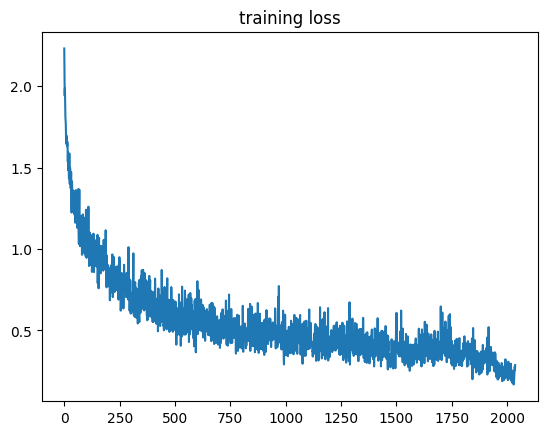

In [115]:
# Evaluate on the validation set
predict = predictor(model, transform)

print()
perc = evaluate(losses, predict, valid_set)
print()
print("Validation set prediction accuracy: ", perc)
